<a href="https://www.kaggle.com/code/vijays140291/credit-r2-score-0-77?scriptVersionId=125609388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('/kaggle/input/credit-risk-customers/credit_customers.csv')
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


# Getting the Preliminary Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

# Creating Preprocess Input

In [48]:
def onehot_encode(df,column):
    df=df.copy()
    dummies=pd.get_dummies(df[column],prefix=column)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    return df

In [73]:
def preprocess_input(df):
    df=df.copy()
    df['foreign_worker']=df['foreign_worker'].apply(lambda x:1 if x=='yes' else 0)
    df['own_telephone']=df['own_telephone'].apply(lambda x:1 if x=='yes' else 0)
    
    job_encoding={'skilled':0,
      'unskilled resident':1,
      'high qualif/self emp/mgmt':2,
      'unemp/unskilled non res':3}
    df['job']=df['job'].replace(job_encoding)
    
    housing_encoding={'own':0, 'for free':2, 'rent':1}
    df['housing']=df['housing'].replace(housing_encoding)
    
    payment_encoding={'none':0, 'bank':1, 'stores':2}
    df['other_payment_plans']=df['other_payment_plans'].replace(payment_encoding)
    
    property_encoding={'real estate':0,
          'life insurance':1,
          'no known property':2,
          'car':3}
    
    df['property_magnitude']=df['property_magnitude'].replace(property_encoding)
    
    
    personal_status_encoding={'male single':0,
      'female div/dep/mar':1,
      'male div/sep':2,
      'male mar/wid':3}
    df['personal_status']=df['personal_status'].replace(personal_status_encoding)
    
    employment_encoding={'>=7':4, '1<=X<4':2, '4<=X<7':3, 'unemployed':0, '<1':1}
    df['employment']=df['employment'].replace(employment_encoding)
    
    
    parties_encoding={'none':0, 'guarantor':1, 'co applicant':2}
    df['other_parties']=df['other_parties'].replace(parties_encoding)
    
    
    saving_encoding={'no known savings':0,
      '<100':1,
      '500<=X<1000':2,
      '>=1000':3,
      '100<=X<500':4}
    df['savings_status']=df['savings_status'].replace(saving_encoding)
    
    credit_encoding={'critical/other existing credit':0,
      'existing paid':1,
      'delayed previously':2,
      'no credits/all paid':3,
      'all paid':4}
    
    df['credit_history']=df['credit_history'].replace(credit_encoding)
  
    checking_encoding={'<0':0, '0<=X<200':1, 'no checking':2, '>=200':3}
    
    df['checking_status']=df['checking_status'].replace(checking_encoding)
    df['class']=df['class'].apply(lambda x:1 if x=='good' else 0)
    
    df=onehot_encode(df,'purpose')
    
    y=df['class']
    x=df.drop('class',axis=1)
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,shuffle=True)
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x_train.columns)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)
    return x_train,x_test,y_train,y_test

In [74]:
x_train,x_test,y_train,y_test=preprocess_input(df)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 29)
(300, 29)
(700,)
(300,)


# Training the Models

In [91]:
models={'Random Forest Classifier':RandomForestClassifier(),
       'Decision Tree Classifier':DecisionTreeClassifier(),
       'Logistic Regression':LogisticRegression(),
       'Neural Network': MLPClassifier()}

In [95]:
for name, model in models.items():
    model.fit(x_train,y_train)
    print(name)
    print(model.score(x_test,y_test))

Random Forest Classifier
0.78
Decision Tree Classifier
0.7
Logistic Regression
0.74
Neural Network
0.7466666666666667


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Confusion Matrix Classification Report

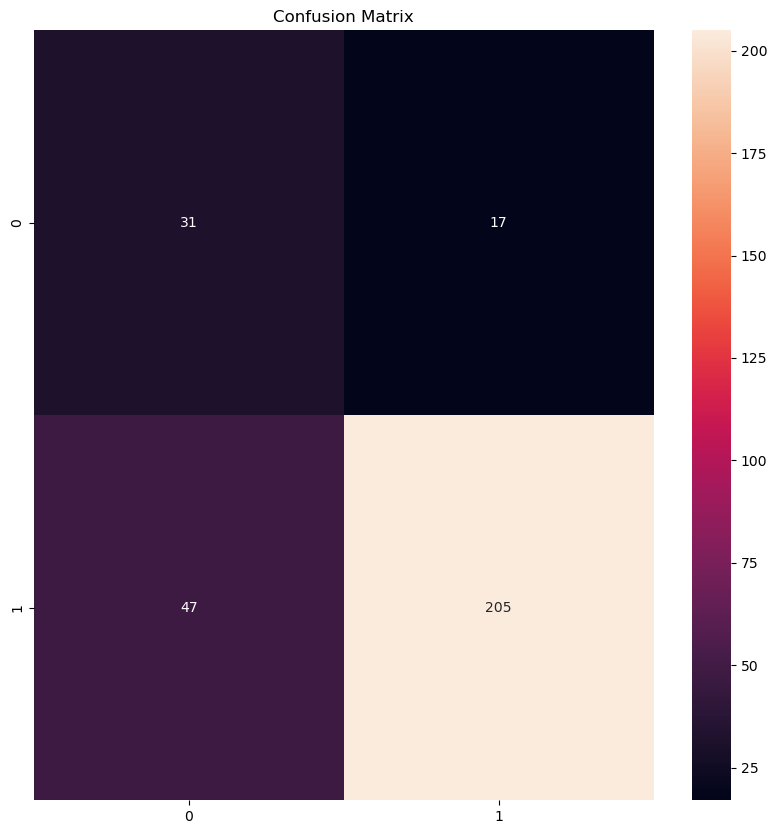

In [99]:
model=RandomForestClassifier()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
cm=confusion_matrix(y_pred,y_test)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [89]:
clr=classification_report(y_pred,y_test)
print(clr)

              precision    recall  f1-score   support

           0       0.46      0.61      0.53        59
           1       0.90      0.83      0.86       241

    accuracy                           0.78       300
   macro avg       0.68      0.72      0.69       300
weighted avg       0.81      0.78      0.79       300



 0       0.46      0.61      0.53        59
           1       0.90      0.83      0.86       241

    accuracy                           0.78       300
   macro avg       0.68      0.72      0.69       300
weighted avg       0.81      0.78      0.79       300

# Unique Values in Each column

In [15]:
{column:list(df[column].unique()) for column in df[df.columns].select_dtypes('object').columns}

{'checking_status': ['<0', '0<=X<200', 'no checking', '>=200'],
 'credit_history': ['critical/other existing credit',
  'existing paid',
  'delayed previously',
  'no credits/all paid',
  'all paid'],
 'purpose': ['radio/tv',
  'education',
  'furniture/equipment',
  'new car',
  'used car',
  'business',
  'domestic appliance',
  'repairs',
  'other',
  'retraining'],
 'savings_status': ['no known savings',
  '<100',
  '500<=X<1000',
  '>=1000',
  '100<=X<500'],
 'employment': ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'],
 'personal_status': ['male single',
  'female div/dep/mar',
  'male div/sep',
  'male mar/wid'],
 'other_parties': ['none', 'guarantor', 'co applicant'],
 'property_magnitude': ['real estate',
  'life insurance',
  'no known property',
  'car'],
 'other_payment_plans': ['none', 'bank', 'stores'],
 'housing': ['own', 'for free', 'rent'],
 'job': ['skilled',
  'unskilled resident',
  'high qualif/self emp/mgmt',
  'unemp/unskilled non res'],
 'own_telephone': ['yes'

In [10]:
df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

In [14]:
df[df.columns].select_dtypes('object').columns

Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [51]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   checking_status              1000 non-null   int64  
 1   duration                     1000 non-null   float64
 2   credit_history               1000 non-null   int64  
 3   credit_amount                1000 non-null   float64
 4   savings_status               1000 non-null   int64  
 5   employment                   1000 non-null   int64  
 6   installment_commitment       1000 non-null   float64
 7   personal_status              1000 non-null   int64  
 8   other_parties                1000 non-null   int64  
 9   residence_since              1000 non-null   float64
 10  property_magnitude           1000 non-null   int64  
 11  age                          1000 non-null   float64
 12  other_payment_plans          1000 non-null   int64  
 13  housing            

In [63]:
y_train

794    0
47     0
83     0
762    0
945    0
      ..
986    0
55     0
438    0
970    0
612    0
Name: class, Length: 700, dtype: int64

In [72]:
y_train.value_counts()

0    700
Name: class, dtype: int64